<a href="https://colab.research.google.com/github/elliemci/building-LLM/blob/main/randomness_control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Text Generation Randomness Control

This notebook contains examples of  two concepts used to control the randomneess and diversity of the model generated.

## Text Generation Strategies

The LLMs generate text one token at a time. The default way called next token is generated is by converting the model output into probability.  scores and selecting the token from the vocabulary that corresponds to the highest probability score

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Colab\ Notebooks/LLM
%ls

/content/drive/MyDrive/Colab Notebooks/LLM
attention_comp.ipynb      __pycache__/                   token_embedding.ipynb
attention_comp.py         pytorch_wormup.ipynb           tokenizing_text.ipynb
gpt_implementation.ipynb  randomness_control.ipynb       training.ipynb
gpt_implementation.py     sliding_window_sampling.ipynb  training.py
gpt_model.png             sliding_window_sampling.py
model.pth                 the-verdict.txt


In [ ]:
!pip install tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 11.3 MB/s eta 0:00:00


In [ ]:
! jupyter nbconvert --to python training.ipynb

[NbConvertApp] Converting notebook training.ipynb to python
[NbConvertApp] Writing 13716 bytes to training.py


In [ ]:
import torch
import tiktoken

from gpt_implementation import GPTModel, generate_text_simple

GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False}

torch.manual_seed(123)

model = GPTModel(GPT_CONFIG_124M)
# load the model weights into a new instance
model.load_state_dict(torch.load("model.pth", map_location=torch.device('cpu')))
# for inferance disable dropout layer
model.eval()

## Temperature Scaling

Temperature Scaling adds a probabilistic selection process to the next token generation task. Probabilistic sampling can be achived replacing torch.argmax with multinomial sampling of the probibility scores the LLM generates for each vocabulary entry at each token generation step.

In [ ]:
# next token generation process example with a small vocabulary;
# apply this vocabulary to convert new text into token IDs
vocab = { "closer": 0,
          "every": 1,
          "effort": 2,
          "forward": 3,
          "inches": 4,
          "moves": 5,
          "pizza": 6,
          "toward": 7,
          "you": 8}

inverse_vocab = {v: k for k, v in vocab.items()}

In [ ]:
inverse_vocab

{0: 'closer',
 1: 'every',
 2: 'effort',
 3: 'forward',
 4: 'inches',
 5: 'moves',
 6: 'pizza',
 7: 'toward',
 8: 'you'}

In [ ]:
# !!!!!!!!!!!! compute next token logits !!!!!!!!!
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

In [ ]:
probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()

print(inverse_vocab[next_token_id])

forward


The multinomial function samples the next token proportional to its probability score

In [ ]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()

print(inverse_vocab[next_token_id])

toward


In [ ]:
def print_sampled_tokens(probas, n_sampling):
  """ Function to print the sampling frequencies of the multinomial sampling that
      repeats n_sampling"""
  torch.manual_seed(123)
  sample = [torch.multinomial(probas, num_samples=1).item() for i in range(n_sampling)]
  sampled_ids = torch.bincount(torch.tensor(sample))
  for i, freq in enumerate(sampled_ids):
      print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas, 1000)

71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


In [ ]:
def softmax_with_temperature(logits, temperature):
  """ Funtion to control the distribution and selection with tempreture scaling,
      dividing the logits by tempreture, where temperature of 1 coresponds to
      unscaled probabilities scores of each token in the vocabulary, decreasing
      the teprature 0 < tempreture < 1 sharpens the distributions, and increasing
      the tempreture, 1 < tempreture makes the distribution more uniform. """

  scaled_logits = logits / temperature
  return torch.softmax(scaled_logits, dim=0)

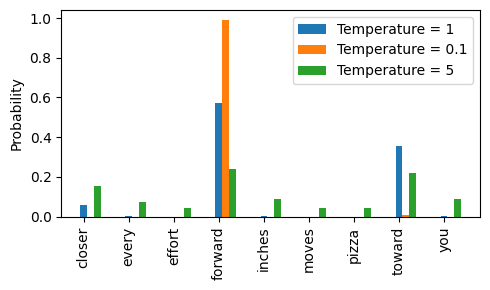

In [ ]:
import matplotlib.pyplot as plt

# plot probabilities with different temperature values
temperatures = [1, 0.1, 5]  # Original, higher, and lower temperature

scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i],
                   bar_width, label=f'Temperature = {T}')
ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

## Top-k sampling

Using top-k sampling focus on the k tokens associated with the highest logits and mask out the other tokens with negative infinity before applying the softmax function, which results in a probability distribution with a probability oflue of 0 assgned to all non-top-k tokens

In [ ]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)

print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [ ]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float('-inf')),
    other=next_token_logits
)
print(f"the top 3 logits, with th erest masked as -inf:\n{new_logits}")

the top 3 logits, with th erest masked as -inf:
tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [ ]:
# turn logits into probabilities
topk_probas = torch.softmax(new_logits, dim=0)
print(f"logits into probabilities:\n{topk_probas}")

logits into probabilities:
tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


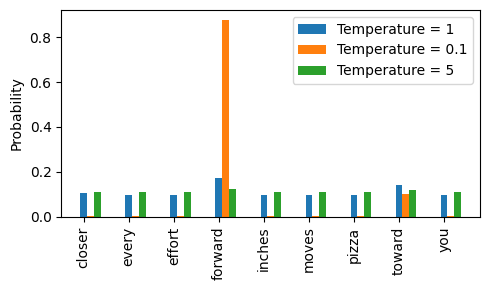

In [ ]:
temperatures = [1, 0.1, 5]  # Original, higher, and lower temperature

scaled_probas = [softmax_with_temperature(topk_probas, T) for T in temperatures]

x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i],
                   bar_width, label=f'Temperature = {T}')
ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

## Generate Text with more diversity

Combine temperature sampling and top-k sampling to increase the diversity of LLM generated text

In [ ]:
def generate(model, idx, max_new_tokens, context_size, temperature, top_k=None):
    """ Combine teperature scaling and top-k sampling to generate new text,
        intead of memorizing one. """
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(
                logits < min_val,
                torch.tensor(float('-inf')).to(logits.device),
                logits
            )
        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

In [ ]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know began to happen a little wild--I was such not to face enough
